# Intro Task, Object Localization

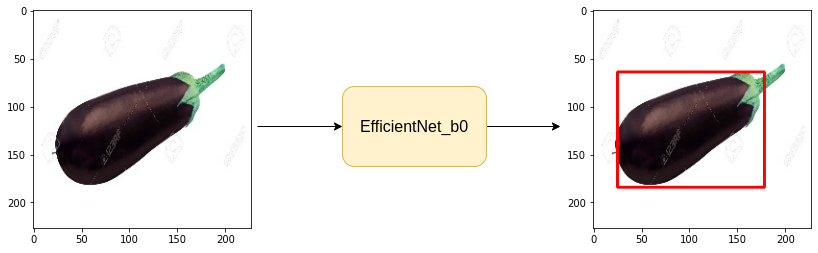

In [ ]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 28.87 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
CSV_FILE="/content/object-localization-dataset/train.csv"
DATA_DIR="/content/object-localization-dataset/"

DEVICE="cuda"

BATCH_SIZE=16
IMG_SIZE=140

LR=0.001
EPOCHS=40
MODEL_NAME="efficientnet_b0"

NUM_CO=4      #no. of coordinate

In [6]:
df=pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

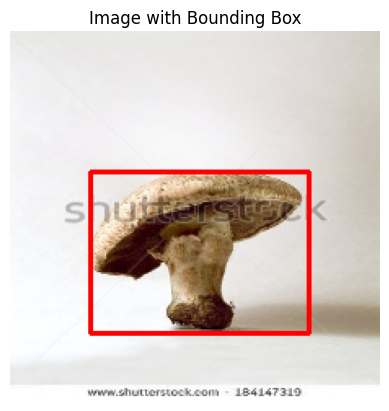

In [7]:
row=df.iloc[2]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR image to RGB
# Proceed with drawing bounding box and displaying the image
pt1 = (int(row.xmin), int(row.ymin))
pt2 = (int(row.xmax), int(row.ymax))
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)

plt.imshow(bnd_box_img)
plt.axis('off')
plt.title('Image with Bounding Box')
plt.show()

In [8]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [9]:
import albumentations as A

In [10]:
#there is difference between the augmentaion for classificationa and detection or localization
#here we use localization
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),  # Resize images to a specified size
    A.HorizontalFlip(p=0.5),       # Randomly flip images horizontally with a probability of 0.5
    A.VerticalFlip(p=0.5),         # Randomly flip images vertically with a probability of 0.5
    A.Rotate()                     # Randomly rotate images
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))  #In this format, bounding boxes are represented by four values: x_min, y_min, x_max, and y_max.


valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)  # Resize images to a specified size
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


# Create Custom Dataset

In [11]:
class ObjectLocalizationDataset(torch.utils.data.Dataset):

    def __init__(self, df, augmentations=None):
        super().__init__()
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax

        bbox = [[xmin, ymin, xmax, ymax]]

        img_path = DATA_DIR + row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR image to RGB

        if self.augmentations is not None:
            augmented = self.augmentations(image=img, bboxes=bbox, class_labels=[None])
            img = augmented['image']
            bbox = augmented['bboxes'][0]

        # Convert image to PyTorch tensor and normalize to [0, 1]
        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0  # (H, W, C) -> (C, H, W)
        bbox = torch.tensor(bbox, dtype=torch.float32)

        return img, bbox


In [12]:
trainset=ObjectLocalizationDataset(train_df, augmentations=train_augs)
validset=ObjectLocalizationDataset(valid_df, augmentations=valid_augs)

In [13]:
print(f"Total no. of train samples : {len(trainset)}")
print(f"Total no. of valid samples : {len(validset)}")

Total no. of train samples : 148
Total no. of valid samples : 38


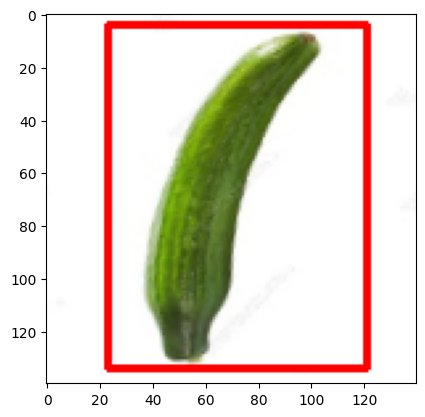

In [14]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [15]:
trainloader=torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader=torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [17]:
for images, bboxes in trainloader:
    break

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [18]:
from torch import nn
import timm

In [34]:
import torch.nn.functional as F

class ObjLocModel(nn.Module):
    def __init__(self):
        super(ObjLocModel, self).__init__()
        self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)

    def forward(self, images, gt_bboxes=None):
        bboxes = self.backbone(images)

        if gt_bboxes is not None:
            loss = self.calc_loss(bboxes, gt_bboxes)
            return bboxes, loss

        return bboxes

    def calc_loss(self, bboxes, gt_bboxes):
        return F.mse_loss(bboxes, gt_bboxes)


In [35]:
model=ObjLocModel()
model.to(DEVICE)


ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): C

# Create Train and Eval Function

In [36]:
def train_fn(model, dataloader, optimizer):
    total_loss=0.0
    model.train() # Dropout ON
    for data in tqdm(dataloader):
        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

        bboxes, loss = model(images, gt_bboxes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [37]:
def eval_fn(model, dataloader):
    total_loss = 0
    model.eval() # Dropout OFF
    with torch.no_grad(): # No need to calculate gradients
        for data in tqdm(dataloader): # Iterate over the dataloader
            images, gt_bboxes = data
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images, gt_bboxes)

            total_loss += loss.item()

    return total_loss / len(dataloader)


#Training Loop

In [38]:
optimizer=torch.optim.Adam(model.parameters(), lr=LR)

In [39]:
best_valid_loss = np.Inf # Initialize the best validation loss to infinity because any loss will be better than that

for epoch in range(EPOCHS):
    # Train the model and calculate the training loss
    train_loss = train_fn(model, trainloader, optimizer)# Train the model and calculate the training loss

    # Validate the model and calculate the validation loss
    valid_loss = eval_fn(model, validloader)

    # Check if the current validation loss is the best we've seen so far
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "best_model.pt")  # Save the model weights
        print("WEIGHTS ARE SAVED")

    # Print the current epoch, training loss, and validation loss
    print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 1, Train Loss: 5355.2961, Valid Loss: 2201.7207


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 2, Train Loss: 2083.1403, Valid Loss: 812.6418


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 3, Train Loss: 1337.3128, Valid Loss: 293.2274


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 4, Train Loss: 799.6687, Valid Loss: 195.4725


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 5, Train Loss: 621.5875, Valid Loss: 182.2036


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 443.4806, Valid Loss: 207.7735


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 7, Train Loss: 343.7637, Valid Loss: 172.1385


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 8, Train Loss: 264.2879, Valid Loss: 162.4120


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 203.3921, Valid Loss: 181.8039


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 10, Train Loss: 168.1705, Valid Loss: 154.3779


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11, Train Loss: 149.8645, Valid Loss: 161.0800


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 12, Train Loss: 113.3002, Valid Loss: 113.2273


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13, Train Loss: 125.0732, Valid Loss: 160.4625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14, Train Loss: 122.8593, Valid Loss: 124.1668


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 15, Train Loss: 98.3582, Valid Loss: 109.9233


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 16, Train Loss: 94.9550, Valid Loss: 91.3272


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17, Train Loss: 81.1068, Valid Loss: 118.7743


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18, Train Loss: 79.2642, Valid Loss: 116.3101


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19, Train Loss: 74.1043, Valid Loss: 98.6493


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20, Train Loss: 75.0859, Valid Loss: 92.2364


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21, Train Loss: 62.7297, Valid Loss: 110.2851


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 22, Train Loss: 49.3101, Valid Loss: 74.0235


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 23, Train Loss: 67.9389, Valid Loss: 72.4186


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24, Train Loss: 67.0026, Valid Loss: 73.5462


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 25, Train Loss: 72.5251, Valid Loss: 67.3622


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch: 26, Train Loss: 55.5781, Valid Loss: 48.3394


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27, Train Loss: 65.3458, Valid Loss: 89.7043


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28, Train Loss: 54.9032, Valid Loss: 73.1564


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29, Train Loss: 64.7638, Valid Loss: 64.8821


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30, Train Loss: 44.2218, Valid Loss: 92.5737


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31, Train Loss: 52.5611, Valid Loss: 76.6879


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32, Train Loss: 45.2907, Valid Loss: 64.8122


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33, Train Loss: 41.1320, Valid Loss: 59.2388


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34, Train Loss: 49.4654, Valid Loss: 63.9574


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35, Train Loss: 44.4819, Valid Loss: 62.2640


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36, Train Loss: 38.0974, Valid Loss: 62.1829


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37, Train Loss: 35.5762, Valid Loss: 78.2804


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38, Train Loss: 29.2764, Valid Loss: 63.1296


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39, Train Loss: 36.5601, Valid Loss: 71.8503


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40, Train Loss: 45.8074, Valid Loss: 78.3805


#Inference

In [40]:
import utils

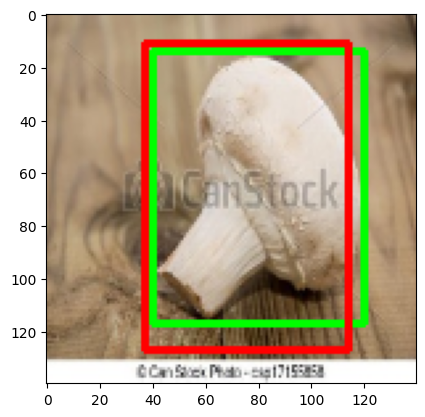

In [45]:
from operator import gt

# Load the model's state dictionary
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

with torch.no_grad():
    image, gt_bbox = validset[23]  # (c,h,w)
    image = image.unsqueeze(0).to(DEVICE)

    # Get the output bounding box predictions from the model
    out_bbox = model(image)

    # If the model's forward method returns a tuple, unpack it
    if isinstance(out_bbox, tuple):
        out_bbox = out_bbox[0]

    # Assuming utils.compare_bboxes function expects tensors on the same device
    utils.compare_plots(image,gt_bbox,out_bbox)
